In [1]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation
import torch_geometric.data
import matplotlib.pyplot as plt

from meld_classifier.paths import NVERT
from meld_graph.dataset import GraphDataset
from meld_classifier.meld_cohort import MeldCohort

from meld_graph.evaluation import Evaluator, sigmoid
import numpy as np
import matplotlib_surface_plotting as msp
import torch

import captum
from captum.attr import IntegratedGradients
from torch import nn

from meld_graph.models import PredictionForSaliency
import matplotlib_surface_plotting as msp

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


In [9]:
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_train_thresholds'
split = 'trainval'


## multi thresholds

In [3]:
# from evaluate_single_model.sh
exp = meld_graph.experiment.Experiment.from_folder(model_name)

cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )
subjects = exp.data_parameters[f'{split}_ids'][100:105]
# print(subjects)
# subjects = ['MELD_H2_3T_C_0001',  'MELD_H2_15T_FCD_0014', 'MELD_H2_15T_FCD_0016', 'MELD_H26_3T_FCD_0004']
features= exp.data_parameters['features']
exp.data_parameters['augment_data']={}

dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode='test')

save_dir = os.path.join(model_name,'fold_all_train_thresholds.2')
 
eva = Evaluator(experiment = exp,
                checkpoint_path = model_name,
                save_dir = save_dir,
                make_images = False,
                dataset=dataset,
                cohort=cohort,
                subject_ids = subjects,
                mode = 'test',
                saliency=True,
                threshold='slope_threshold',)

Initialised Experiment 23-10-30_LVHZ_dcp/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_MaxThresh


Loading and preprocessing test data


MELD_H2_3T_C_0001


Z-scoring data for MELD_H2_3T_C_0001


MELD_H2_15T_FCD_0014


Z-scoring data for MELD_H2_15T_FCD_0014


MELD_H2_15T_FCD_0016


Z-scoring data for MELD_H2_15T_FCD_0016


MELD_H26_3T_FCD_0004


Z-scoring data for MELD_H26_3T_FCD_0004
Evaluation test, min area threshold=100, prediction threshold={'min_thresh': 0.01, 'max_thresh': 0.5, 'slope': 0.25})
Creating model
Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_MaxThresh/best_model.pt
Predicting model without dropout


using dataset


In [4]:
eva.load_predict_data(save_prediction=False)

loading data and predicting model


doing it


In [5]:
eva.threshold_and_cluster(save_prediction=False)

threshold_subj = 0.08225584030151367
threshold_subj = 0.01
threshold_subj = 0.5
threshold_subj = 0.5


In [18]:
eva.data_dictionary['MELD_H2_15T_FCD_0014']['result'].max()

0.0208993

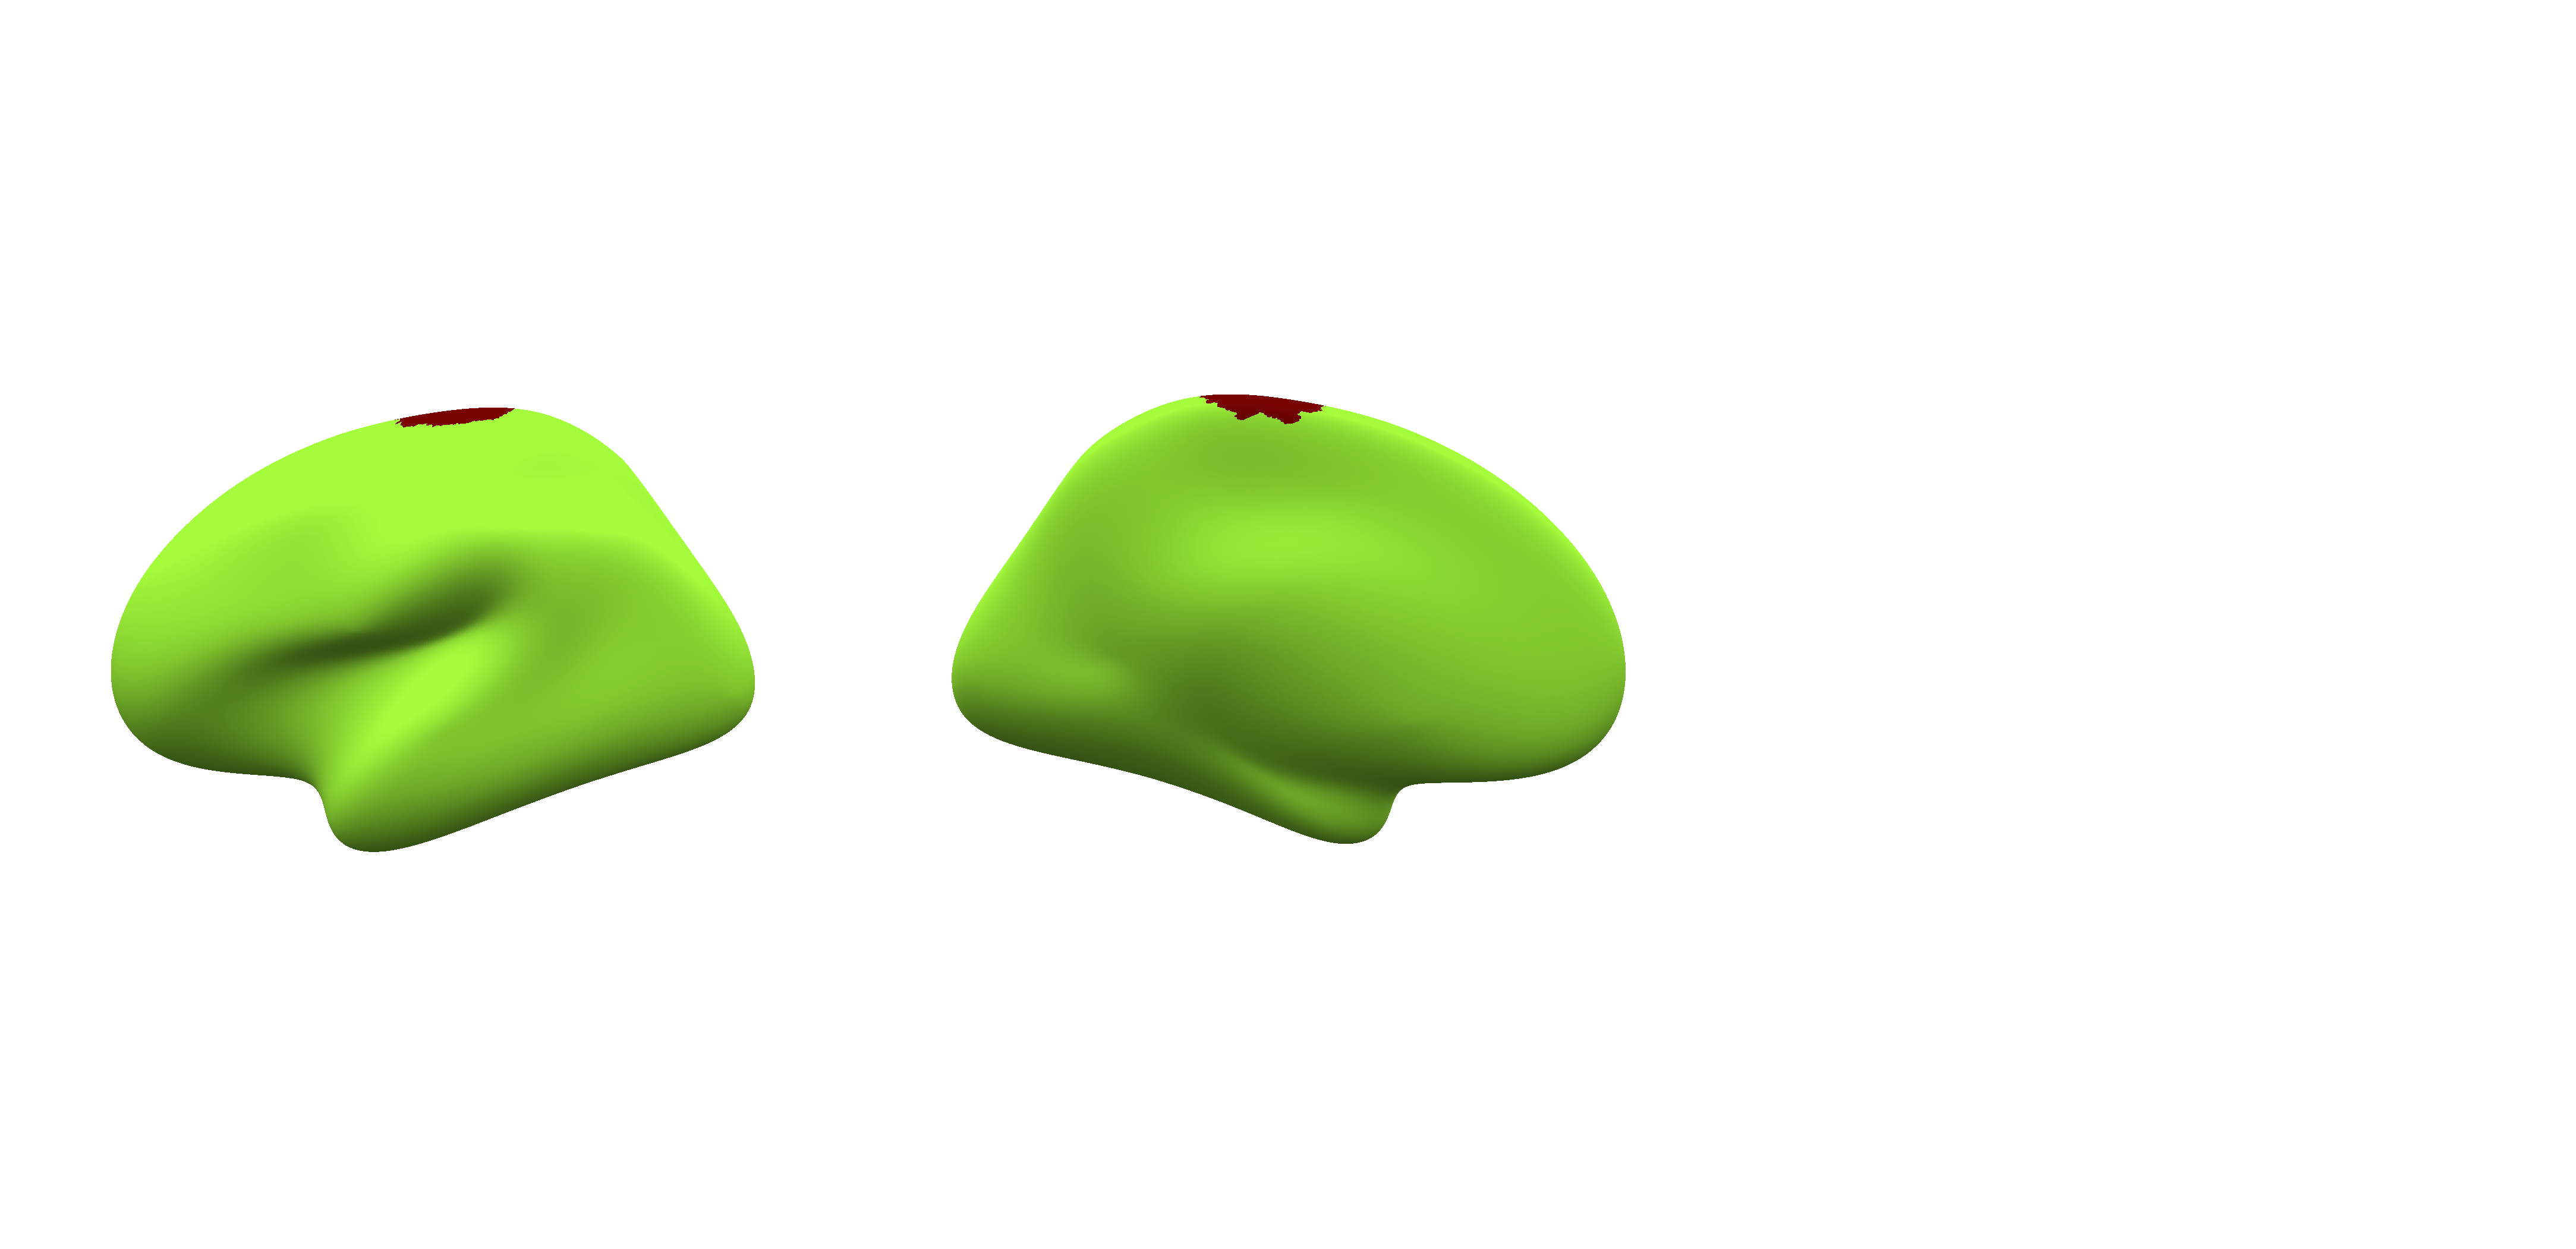

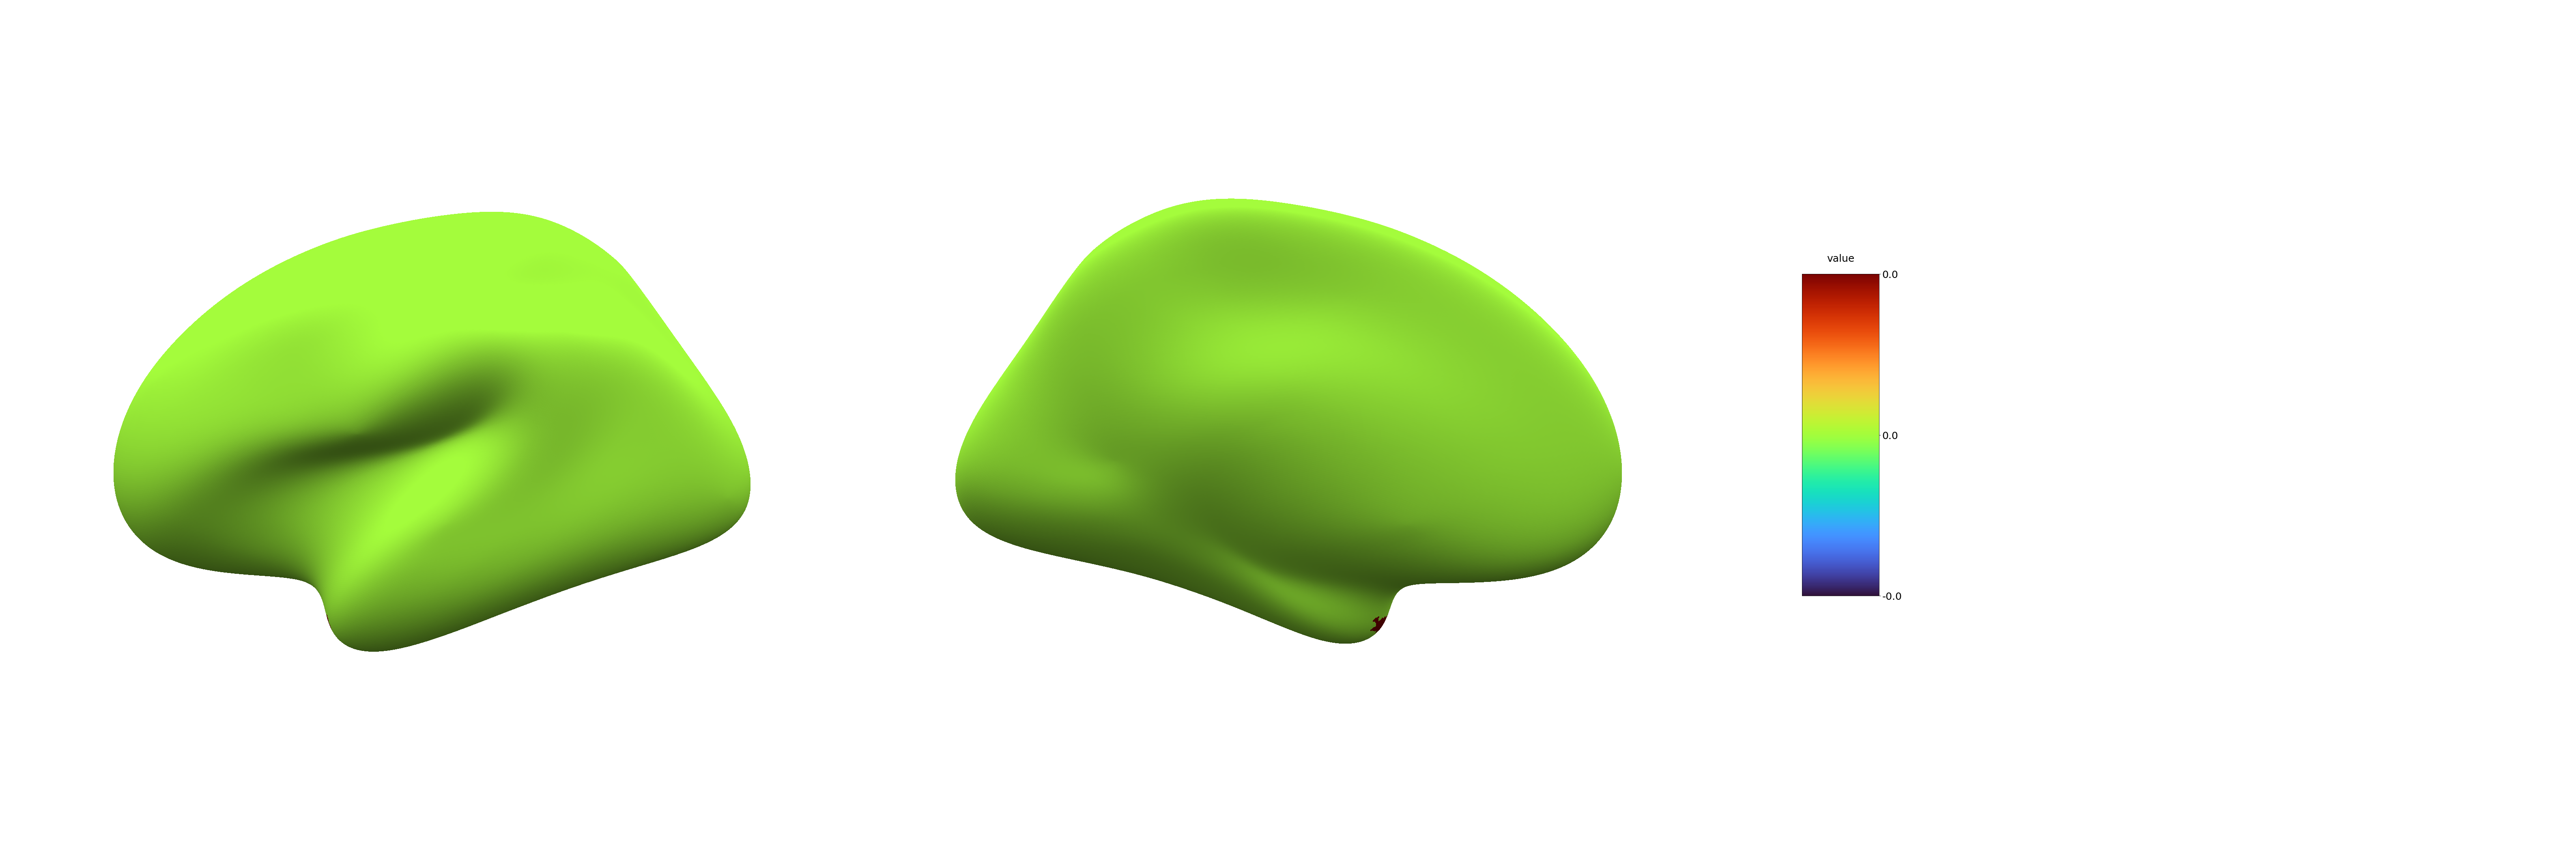

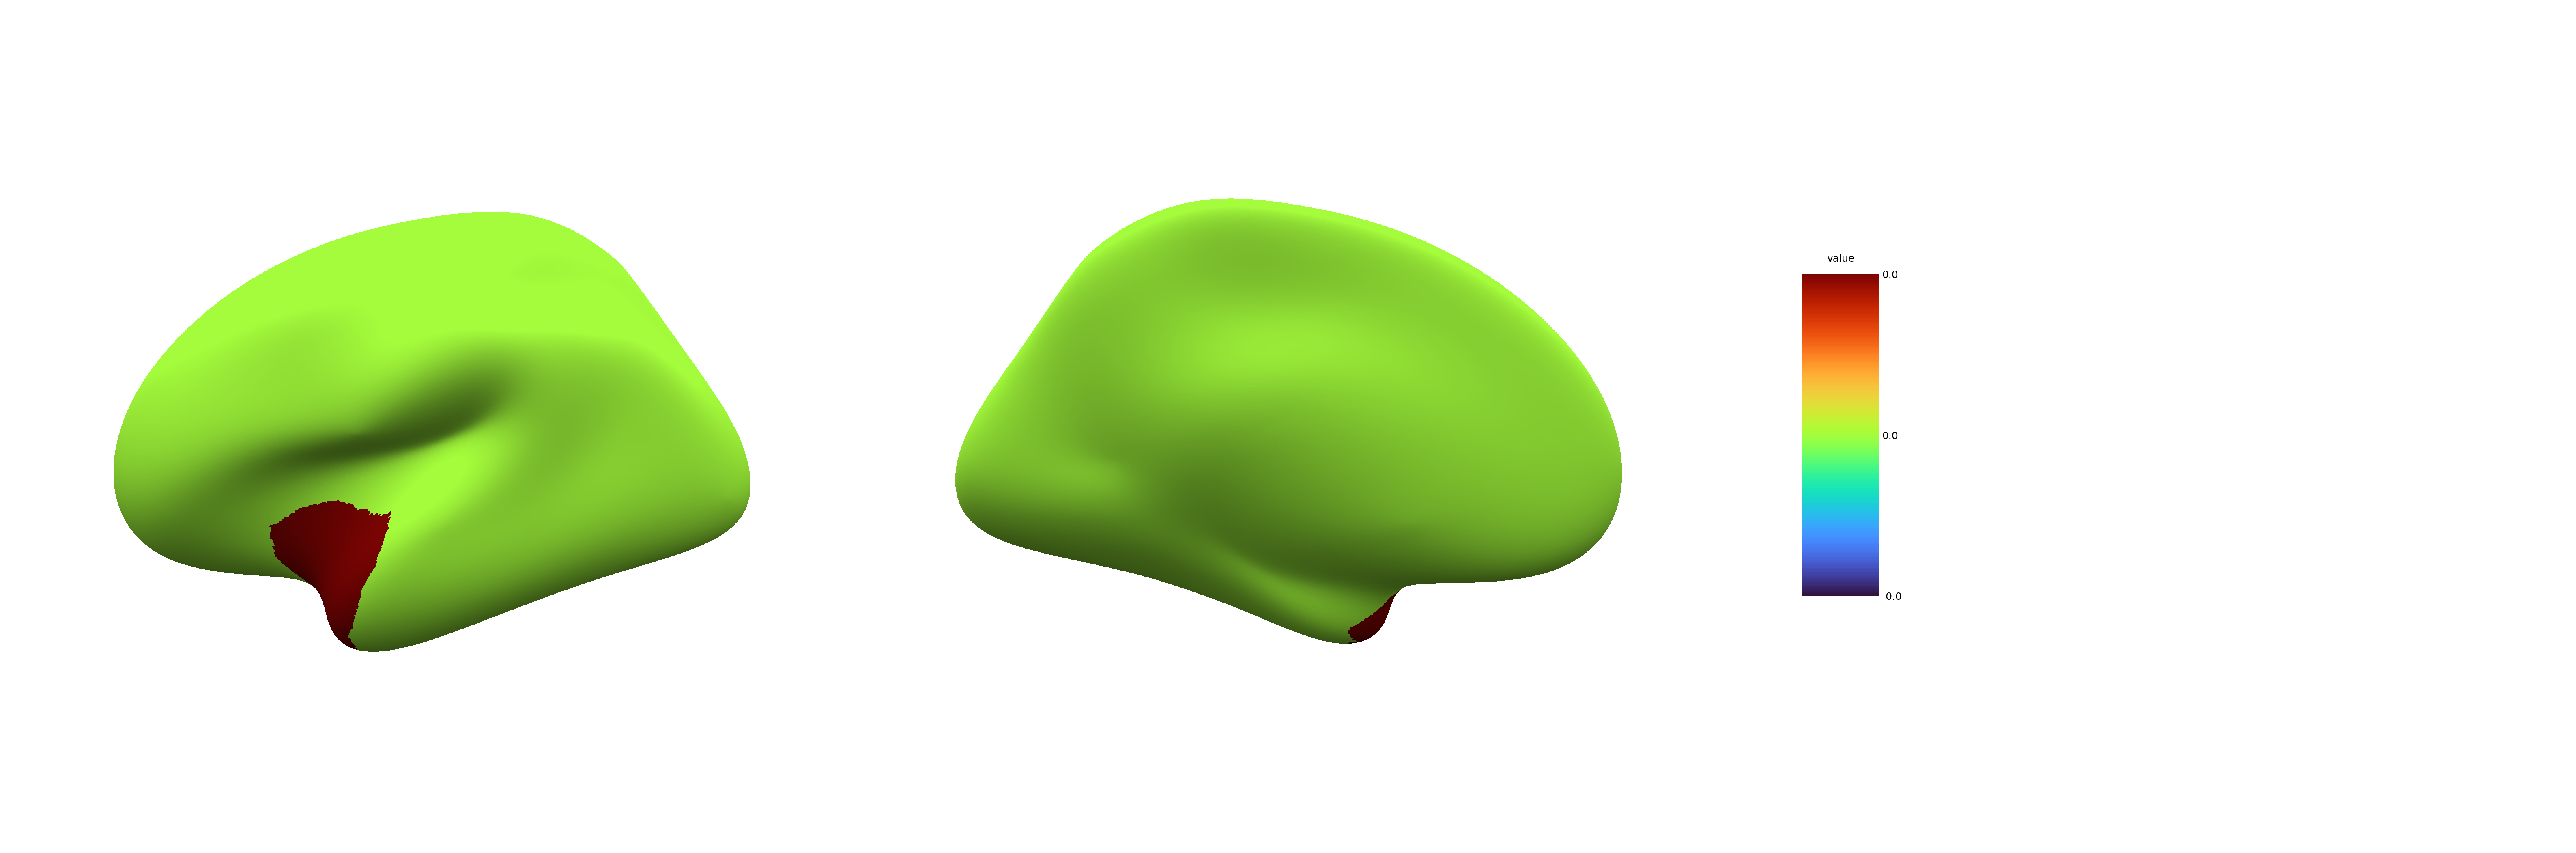

In [6]:
# plot two_threshold results results
data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_3T_C_0001']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['left'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0014']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['left'],
    cmap='turbo',base_size = 30, colorbar=True, 
    vmin = -5e-5, vmax = 5e-5,
    )

data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0016']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['right'],
    cmap='turbo',base_size = 30, colorbar=True, 
    vmin = -5e-5, vmax = 5e-5,
    )

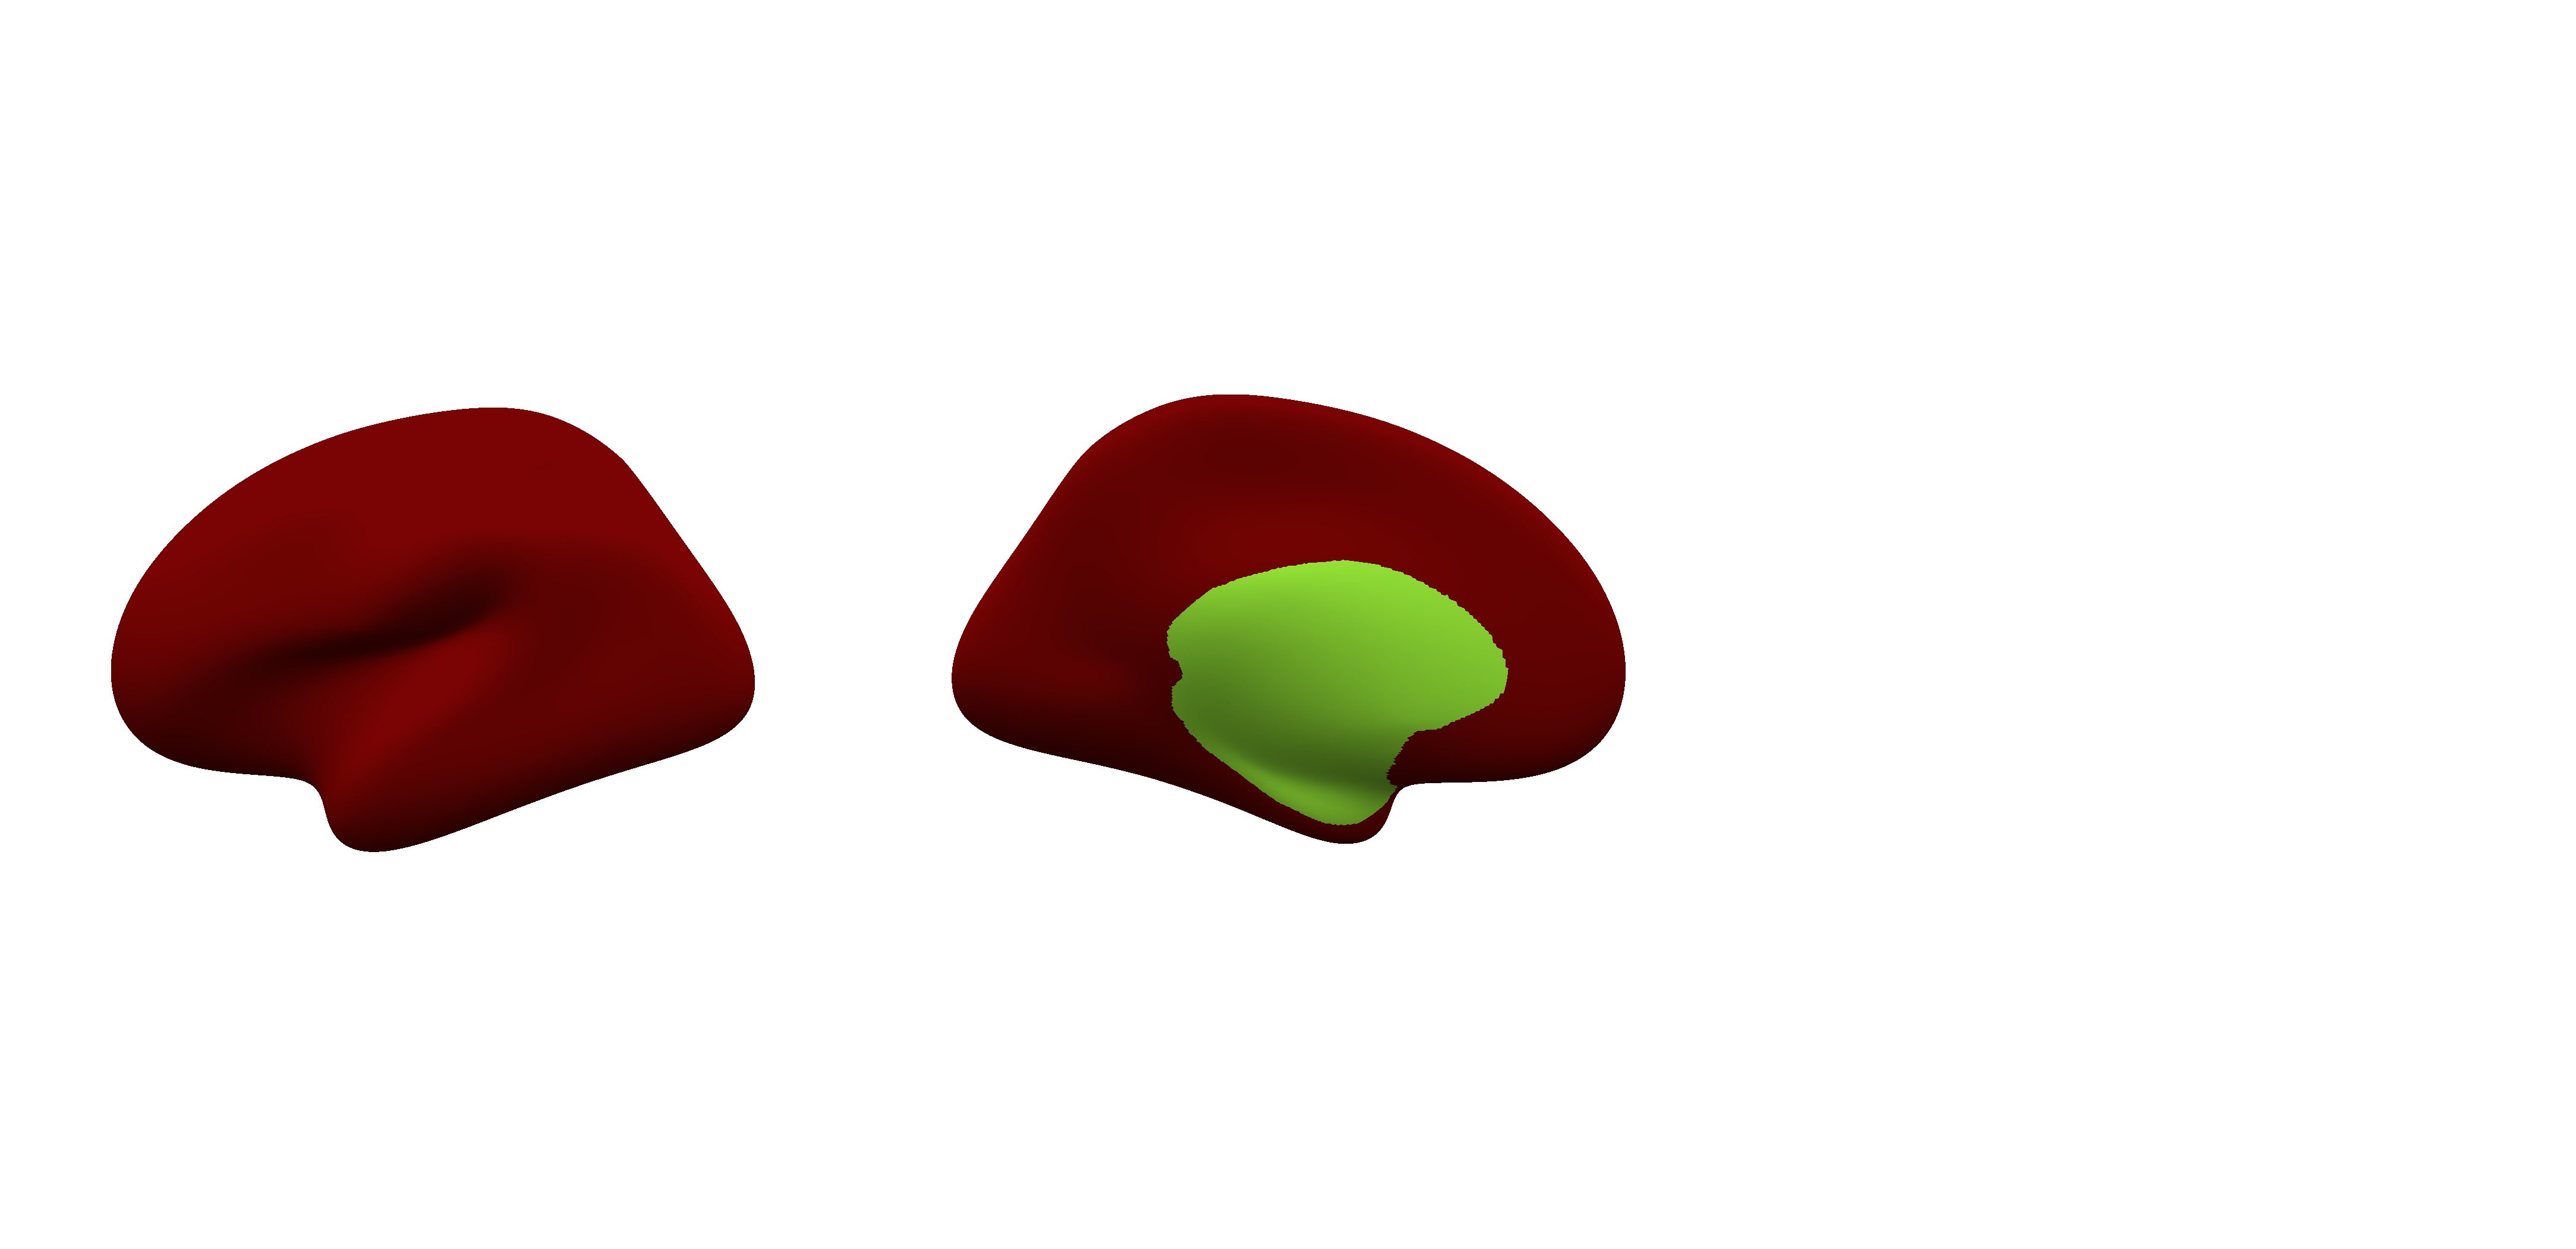

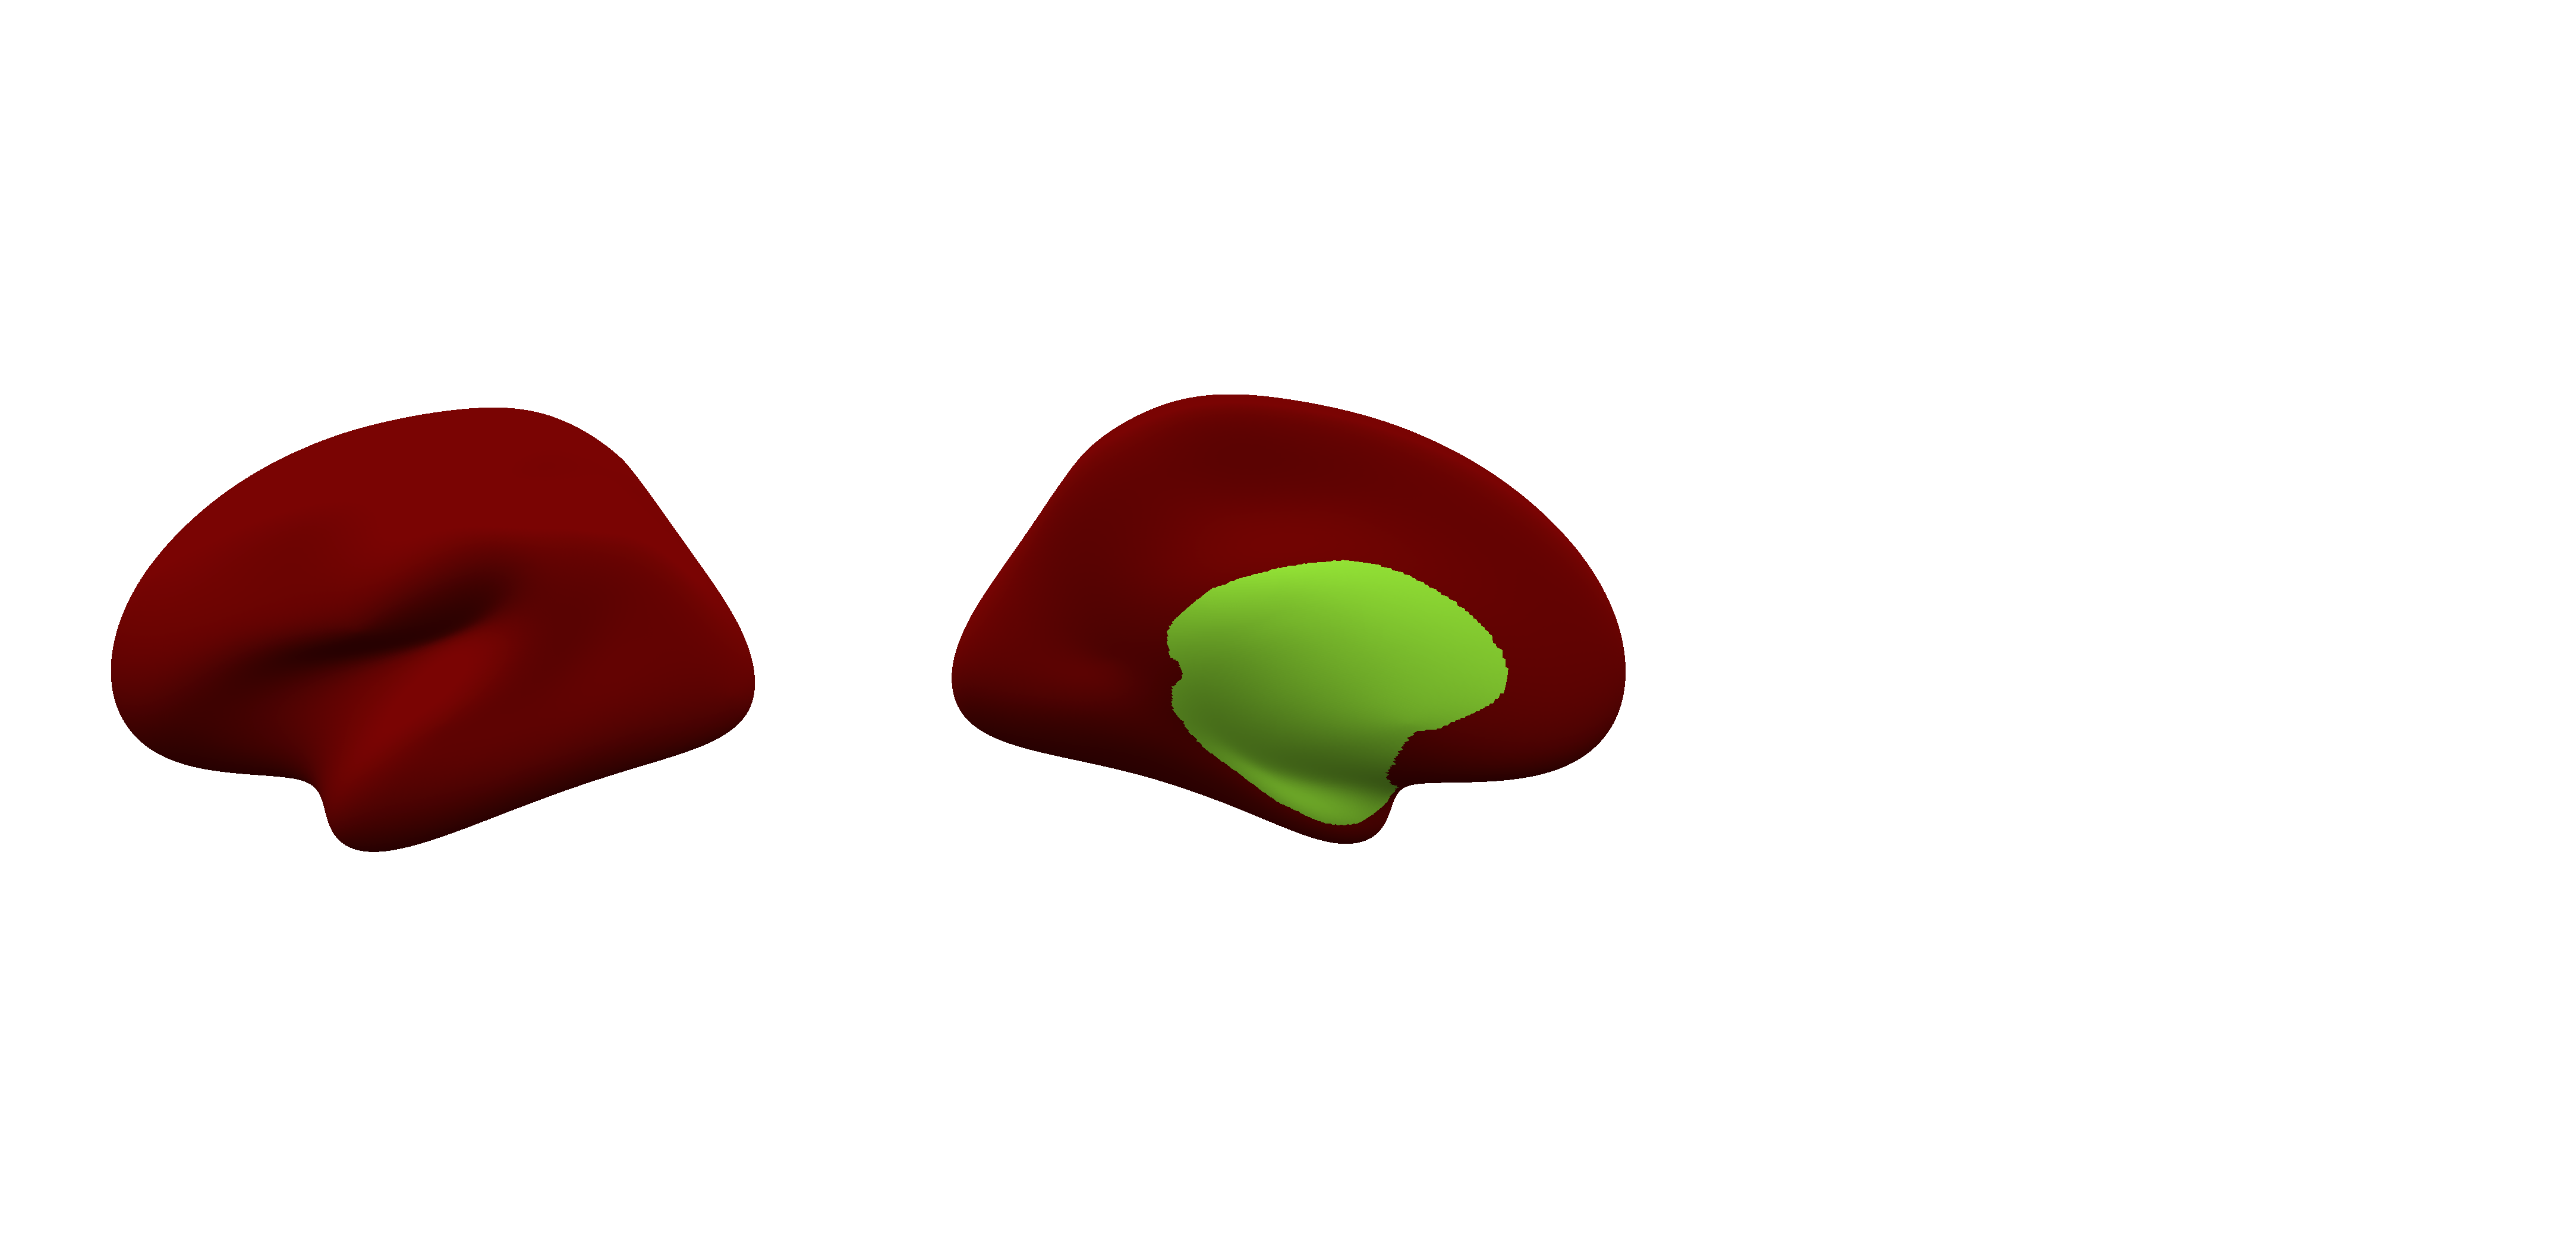

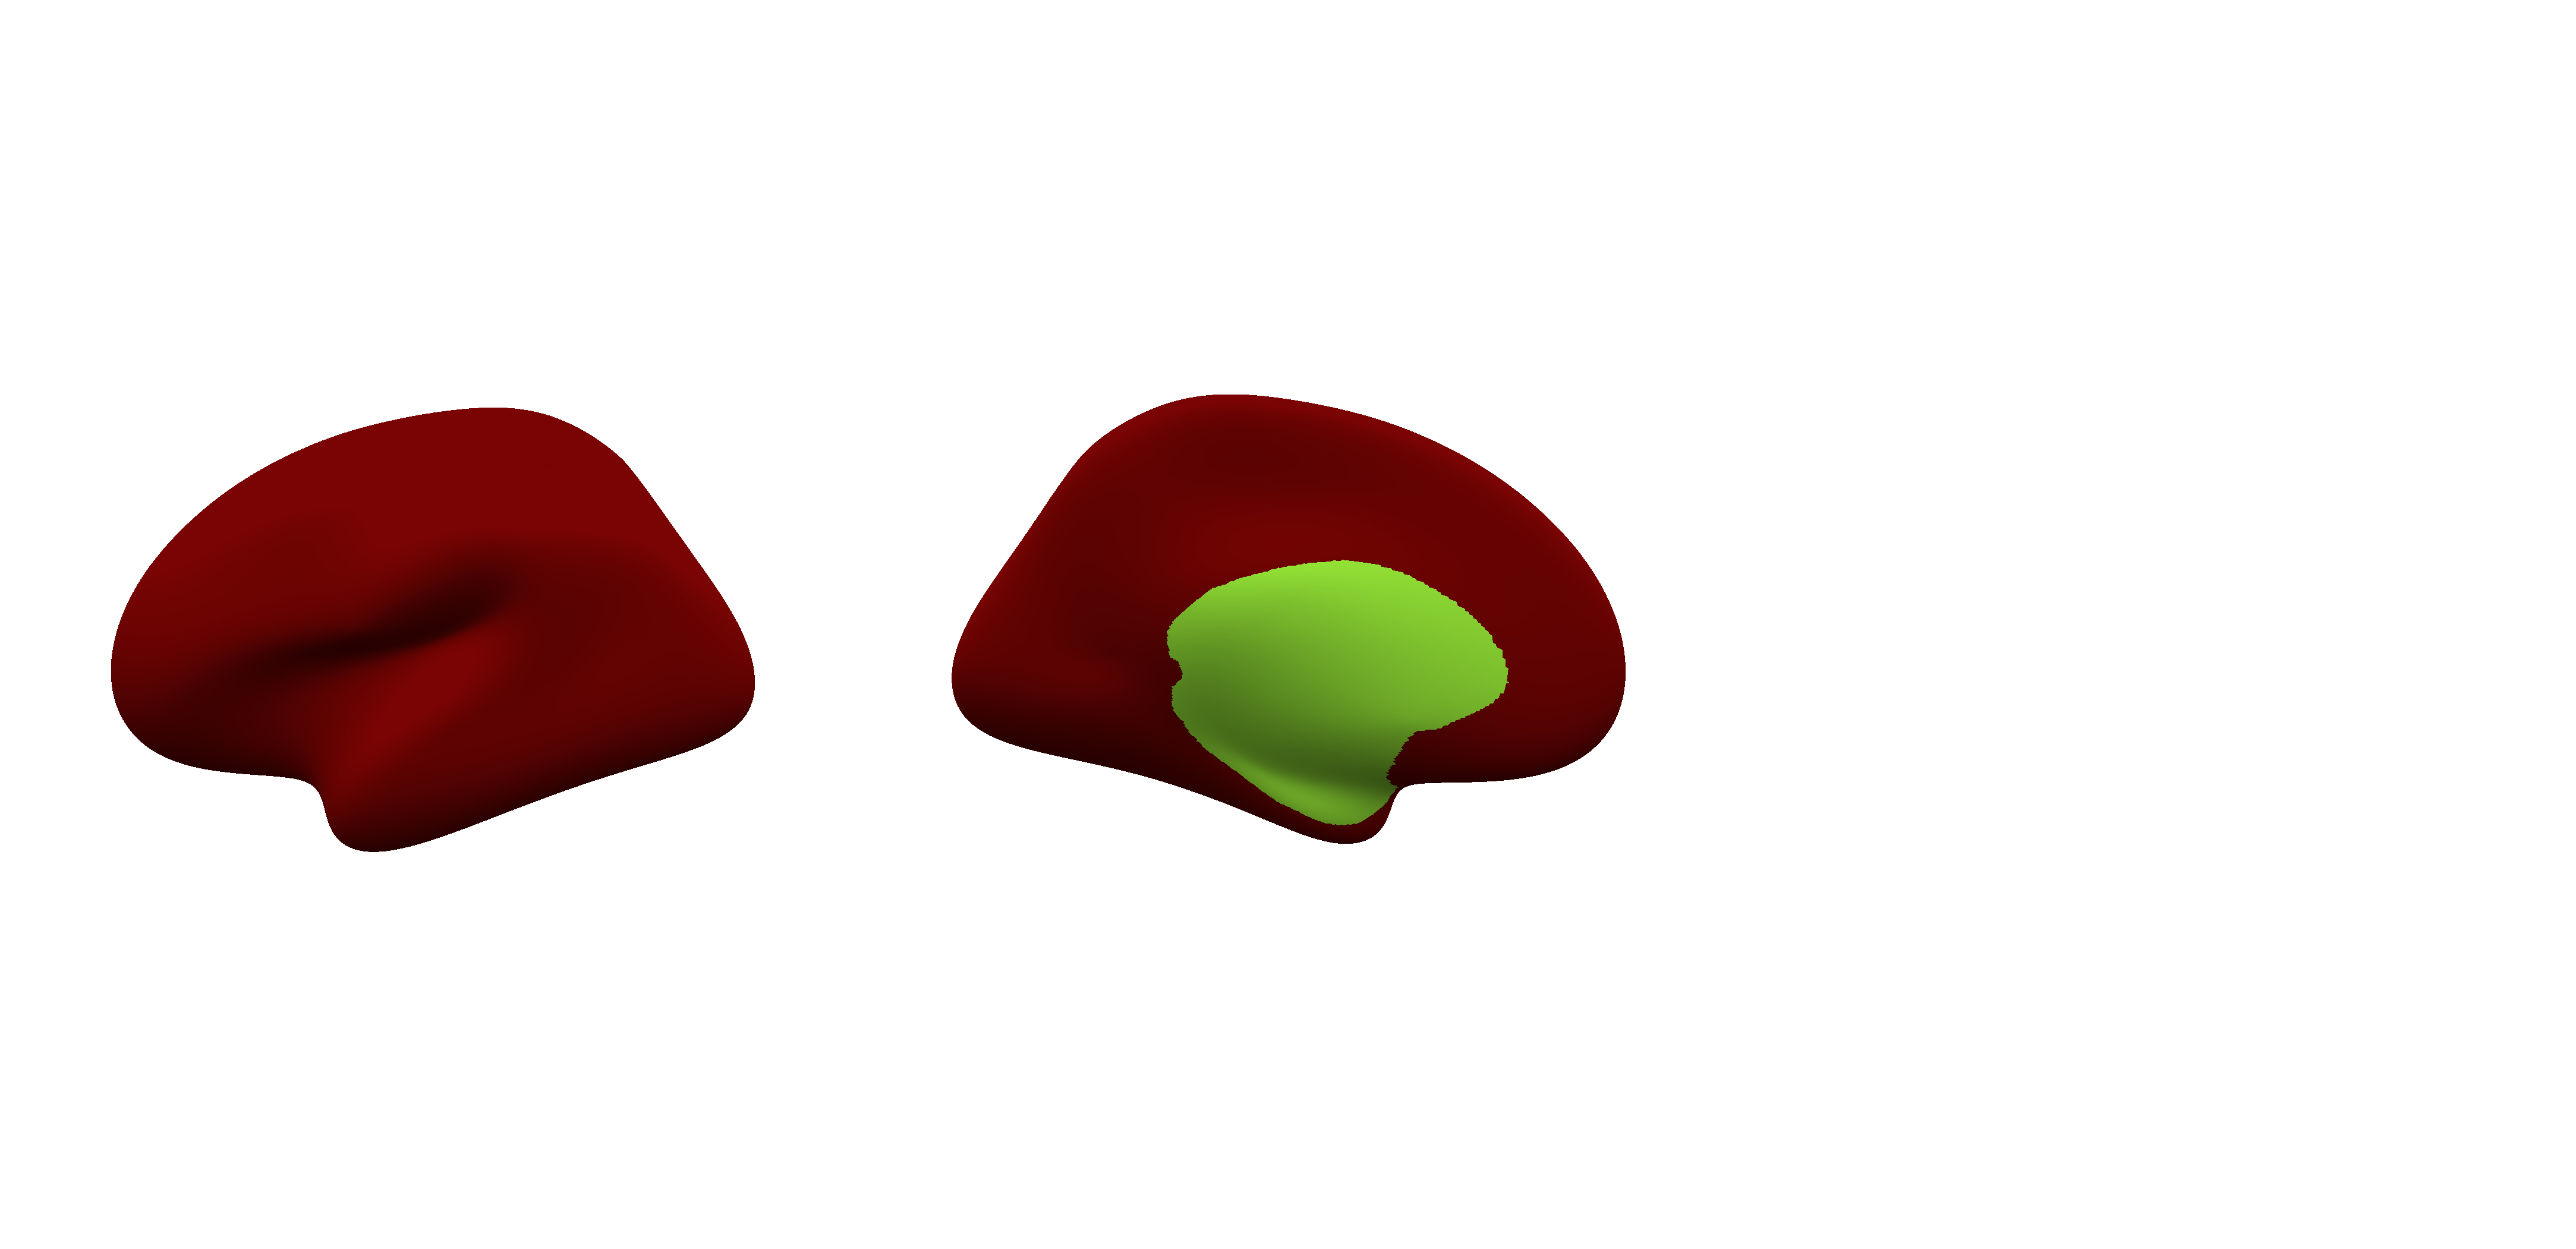

In [20]:
# plot two_threshold results results
data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0001']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['left'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0003']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['left'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0005']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['left'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

## sigmoid

In [40]:
# from evaluate_single_model.sh

exp = meld_graph.experiment.Experiment.from_folder(model_name)
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )
subjects = exp.data_parameters[f'{split}_ids'][5:9]

features= exp.data_parameters['features']
exp.data_parameters['augment_data']={}

dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode='test')

eva = Evaluator(experiment = exp,
                checkpoint_path = model_name,
                save_dir = model_name,
                make_images = False,
                dataset=dataset,
                cohort=cohort,
                subject_ids = subjects,
                mode = 'test',
                saliency=True,
               threshold='sigmoid')

Initialised Experiment 23-10-30_FOPF_dcop/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H2_15T_FCD_0009
Z-scoring data for MELD_H2_15T_FCD_0014
Z-scoring data for MELD_H2_15T_FCD_0015
Z-scoring data for MELD_H2_15T_FCD_0016
Evaluation test, min area threshold=100, threshold sigmoid(ymin=0.1825576901435852, ymax=0.5, k=1.0, m=0.05)
Creating model
Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all/best_model.pt
Predicting model without dropout


using dataset


In [41]:
eva.load_predict_data(save_prediction=False)
eva.threshold_and_cluster(save_prediction=False)

loading data and predicting model


tensor([[-0.1180, -2.1958],
        [-0.1407, -2.0304],
        [-0.1363, -2.0605],
        ...,
        [-0.1292, -2.1100],
        [-0.1376, -2.0514],
        [-0.1345, -2.0724]], grad_fn=<LogBackward0>)
tensor([0.1113, 0.1313, 0.1274,  ..., 0.1212, 0.1286, 0.1259])
tensor([[-0.1191, -2.1871],
        [-0.1182, -2.1941],
        [-0.1250, -2.1414],
        ...,
        [-0.1305, -2.1008],
        [-0.1290, -2.1116],
        [-0.1324, -2.0876]], grad_fn=<LogBackward0>)
tensor([0.1122, 0.1115, 0.1175,  ..., 0.1224, 0.1210, 0.1240])
tensor([[-0.1285, -2.1152],
        [-0.1462, -1.9951],
        [-0.1196, -2.1831],
        ...,
        [-0.1129, -2.2369],
        [-0.1132, -2.2348],
        [-0.1170, -2.2037]], grad_fn=<LogBackward0>)
tensor([0.1206, 0.1360, 0.1127,  ..., 0.1068, 0.1070, 0.1104])
tensor([[-0.1214, -2.1688],
        [-0.1131, -2.2356],
        [-0.1164, -2.2084],
        ...,
        [-0.1176, -2.1990],
        [-0.1144, -2.2246],
        [-0.1175, -2.1994]], grad_fn=<Lo

/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL/meld_graph/evaluation.py:334: RuntimeWarning: invalid value encountered in true_divide
  x = 1 - self.roc_dictionary["specificity"] / self.roc_dictionary["specificity"][-1]


Using sigmoid params: 0.1825576901435852, 0.5, 1.0, 0.05
threshold_subj = 0.5
{'left': array([0.11127497, 0.13127968, 0.12739556, ..., 0.12124182, 0.12855797,
       0.12588041]), 'right': array([0.11224411, 0.11145414, 0.11749152, ..., 0.12236167, 0.12104253,
       0.12398677])} 0.5
Using sigmoid params: 0.1825576901435852, 0.5, 1.0, 0.05
threshold_subj = 0.18255768716335297
{'left': array([0.12060326, 0.13599922, 0.11268772, ..., 0.10678542, 0.10701467,
       0.1103952 ]), 'right': array([0.11431312, 0.10692548, 0.10987712, ..., 0.1109181 , 0.10811555,
       0.11087307])} 0.18255769
Using sigmoid params: 0.1825576901435852, 0.5, 1.0, 0.05
threshold_subj = 0.5
{'left': array([0.13035536, 0.13227062, 0.11846938, ..., 0.1601226 , 0.15473455,
       0.15504692]), 'right': array([0.12311813, 0.1177393 , 0.11310127, ..., 0.11010899, 0.1103064 ,
       0.10798707])} 0.5
Using sigmoid params: 0.1825576901435852, 0.5, 1.0, 0.05
threshold_subj = 0.5
{'left': array([0.11386286, 0.11450829, 0

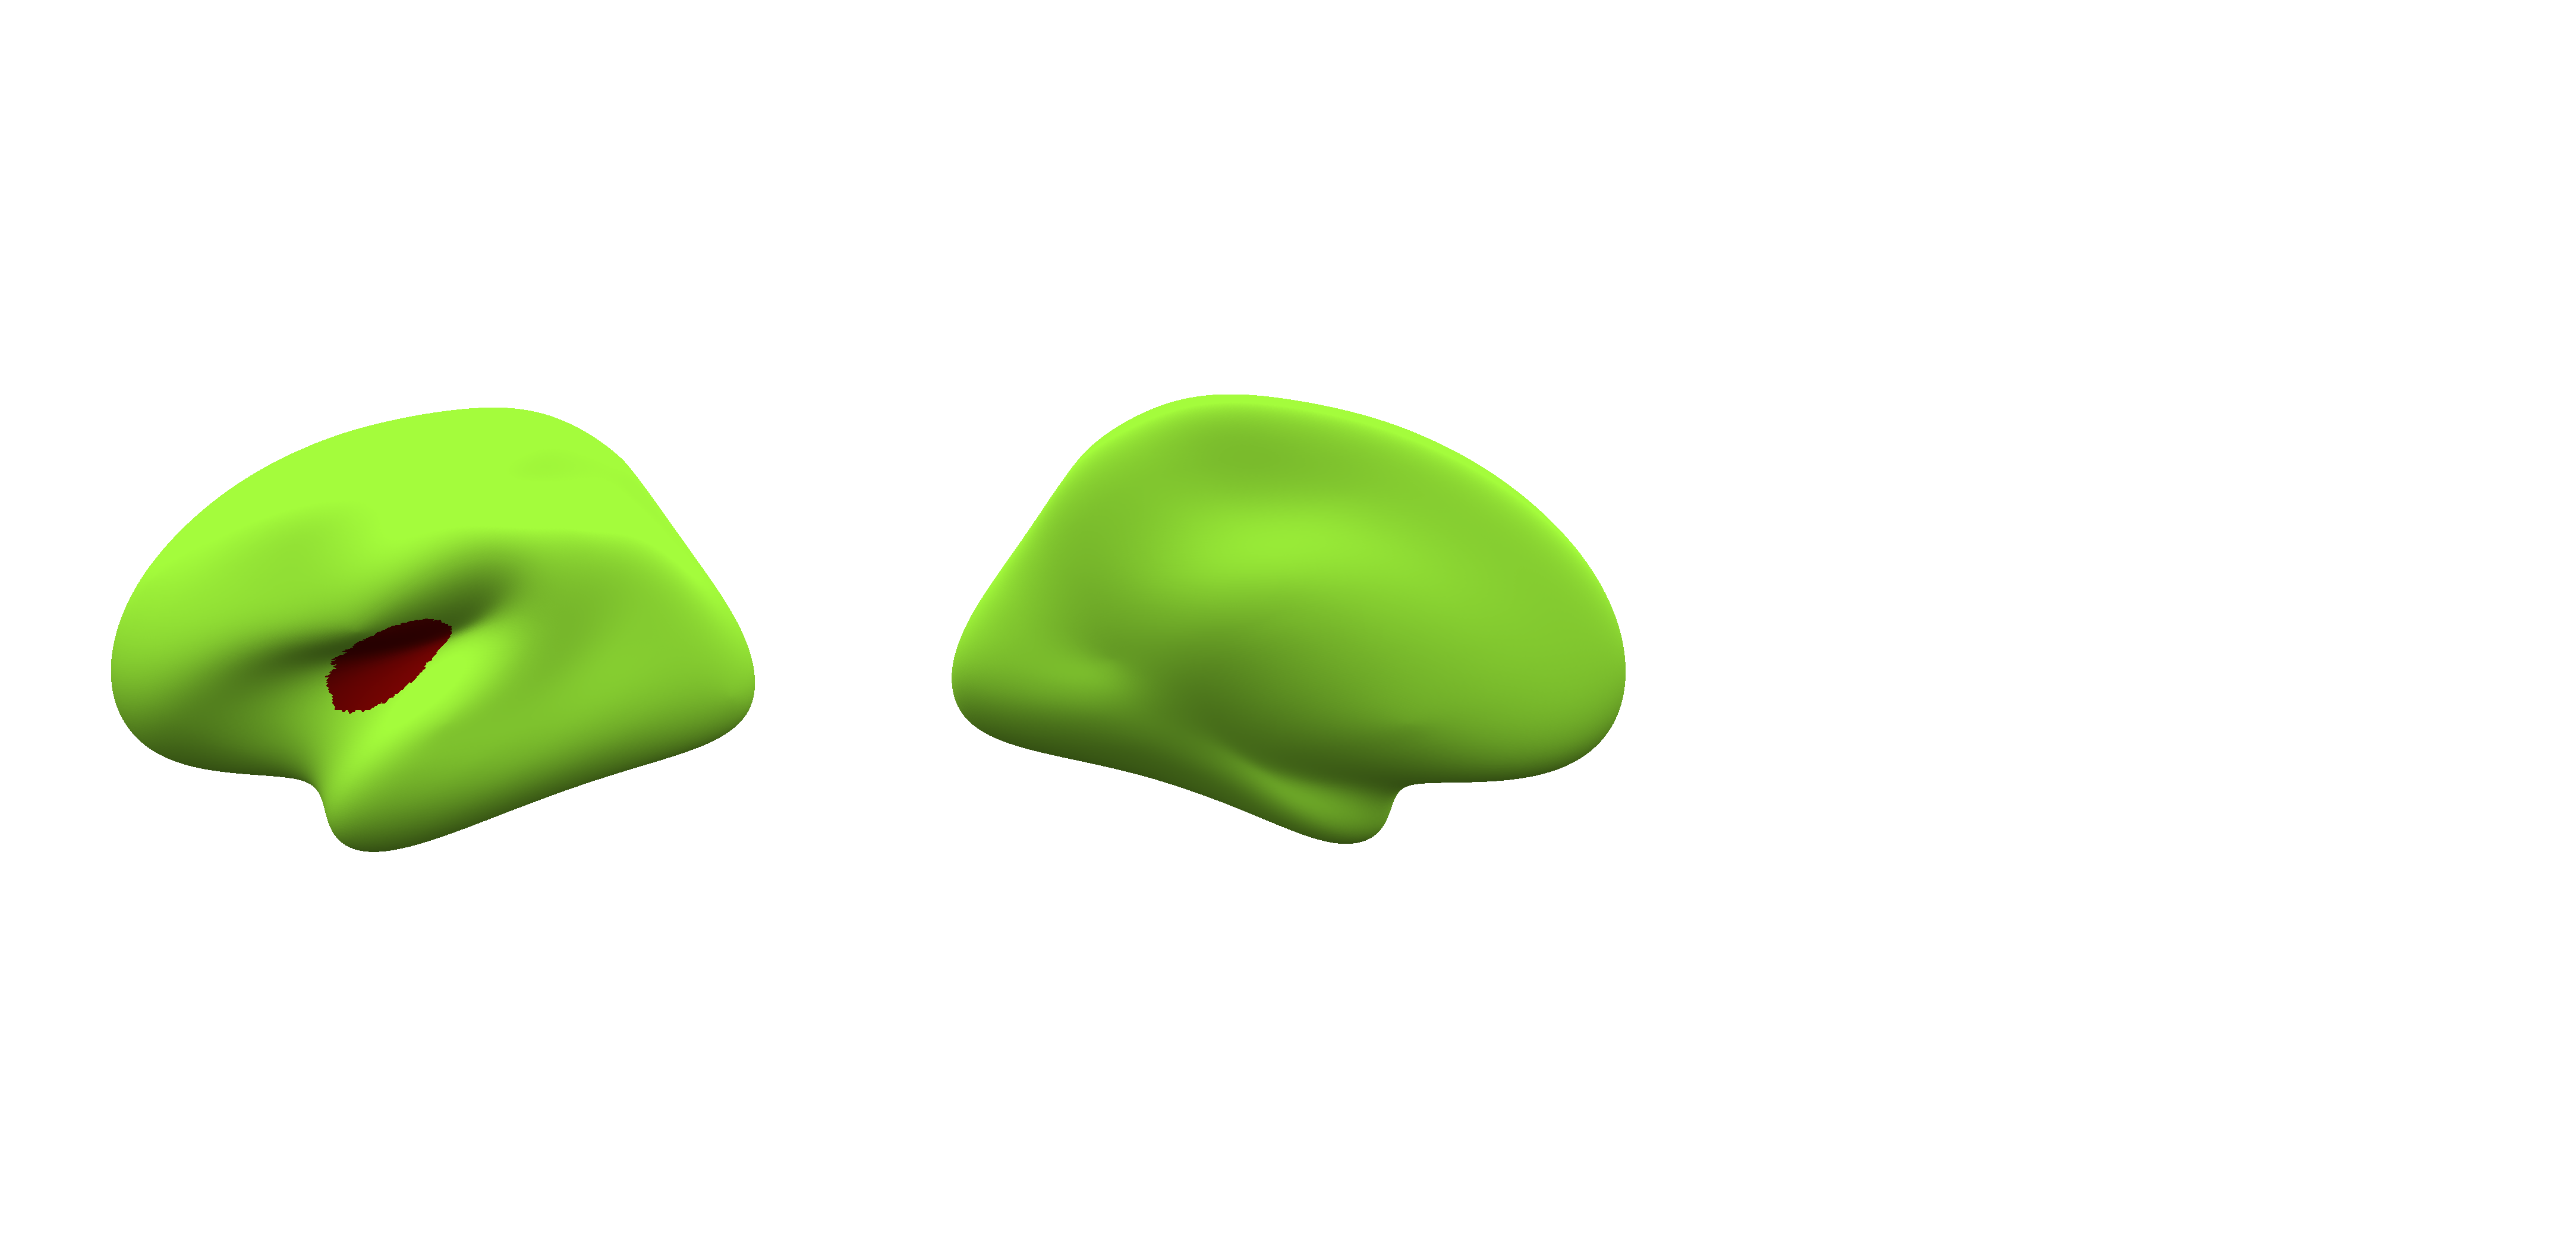

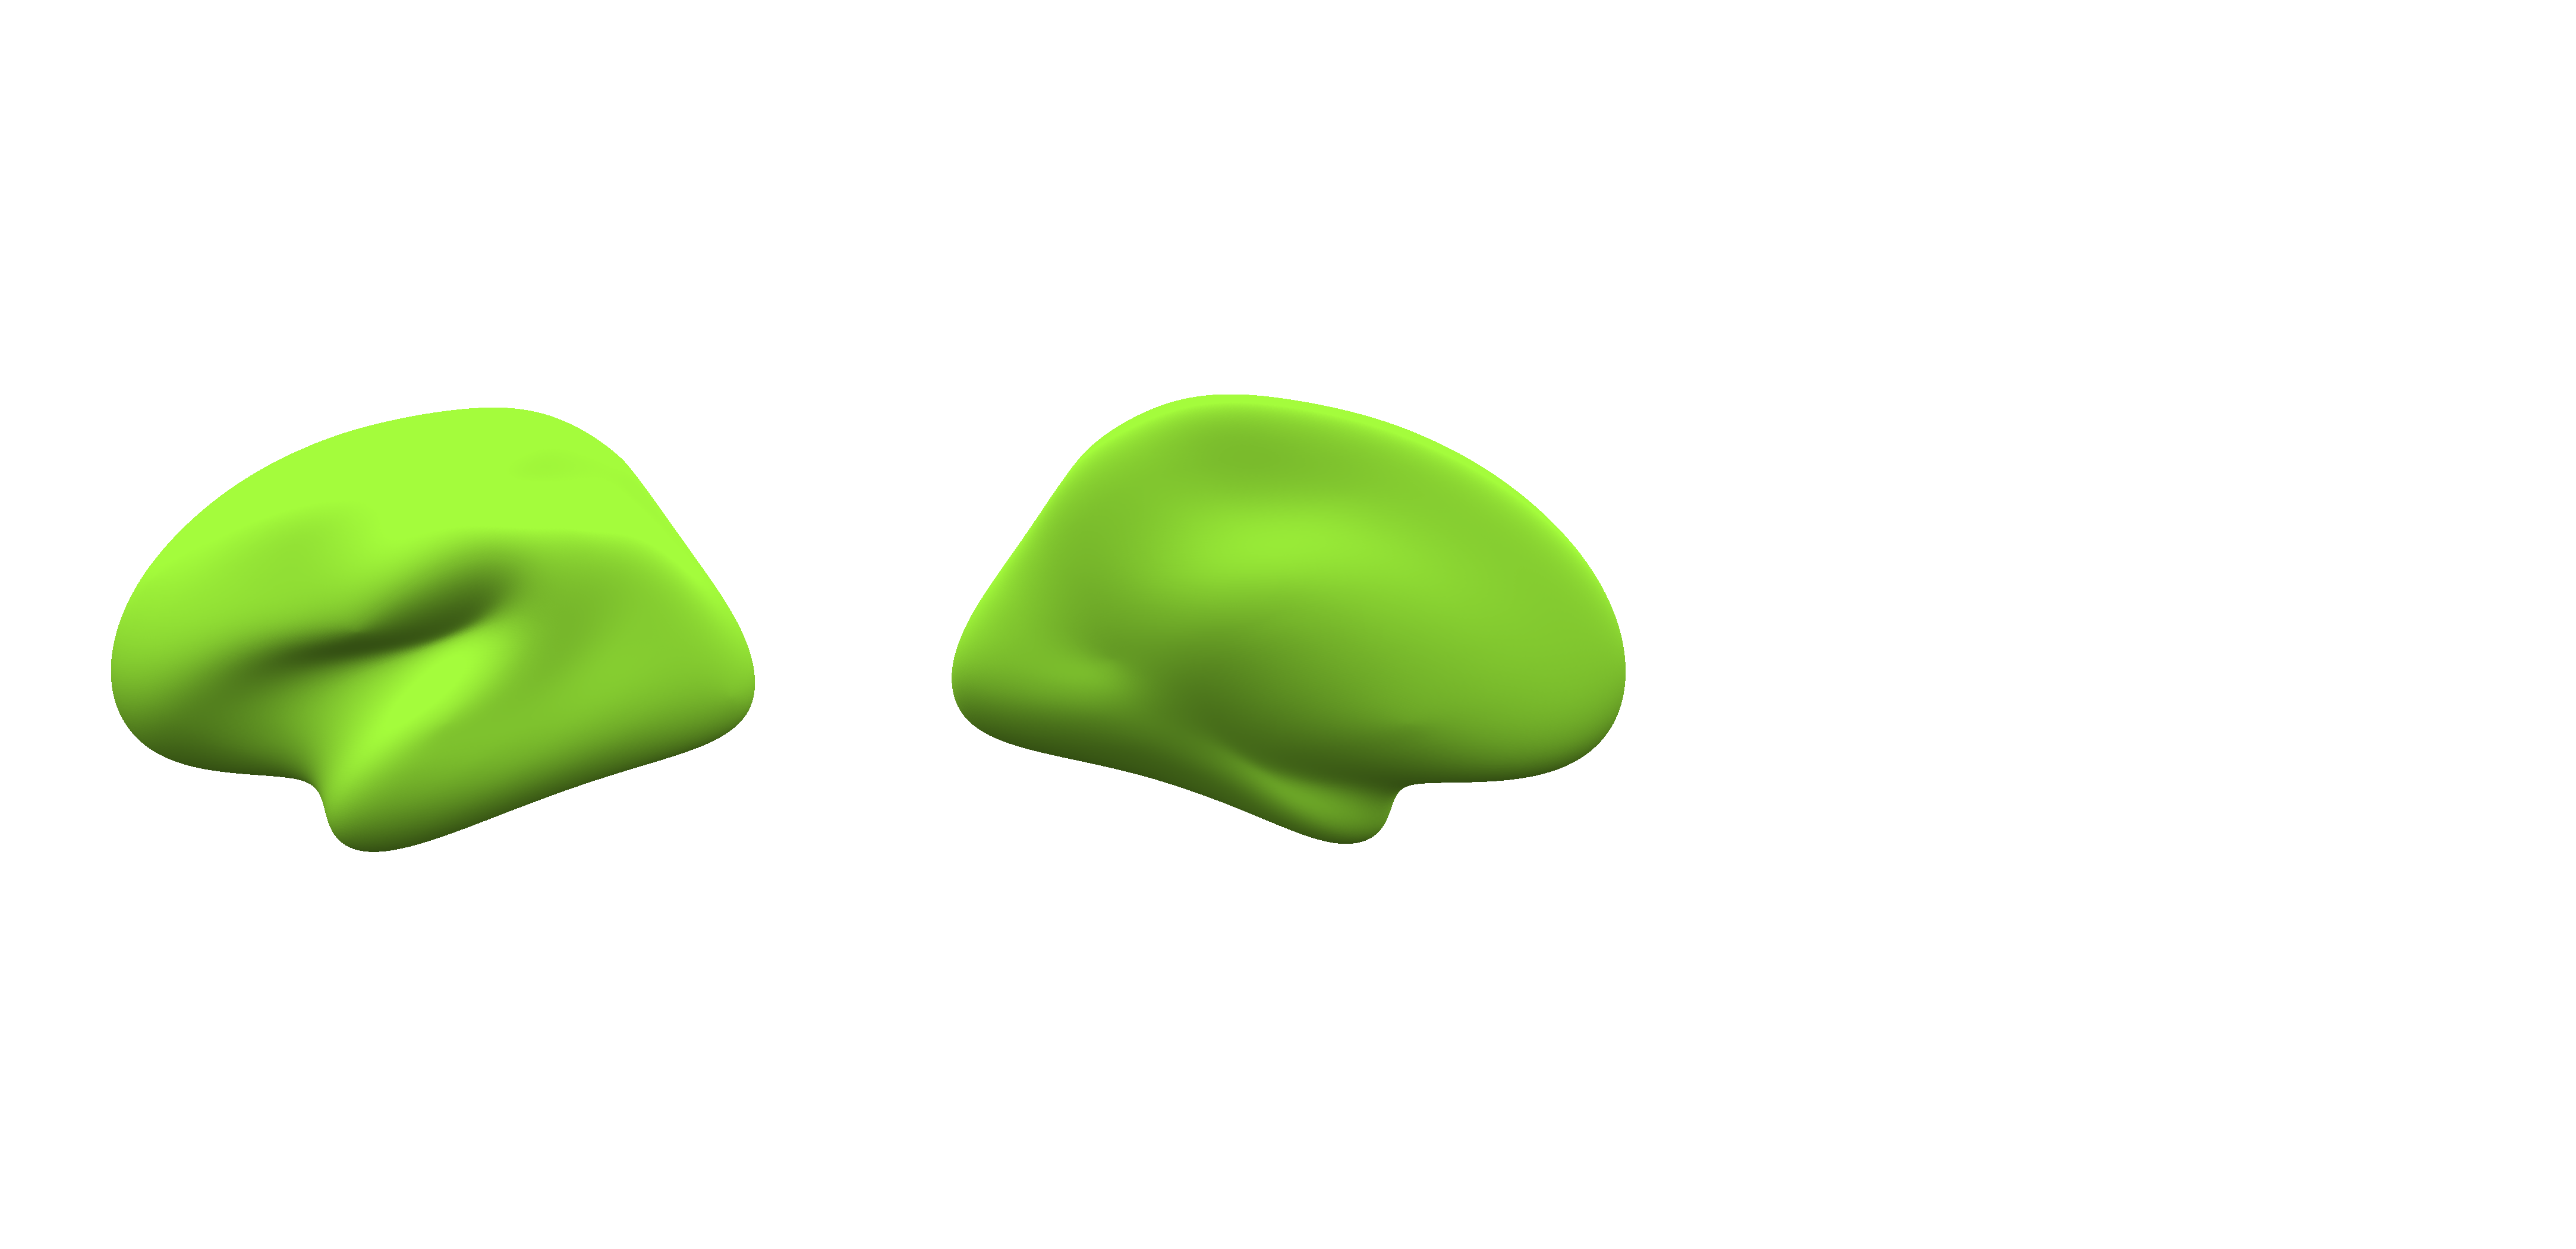

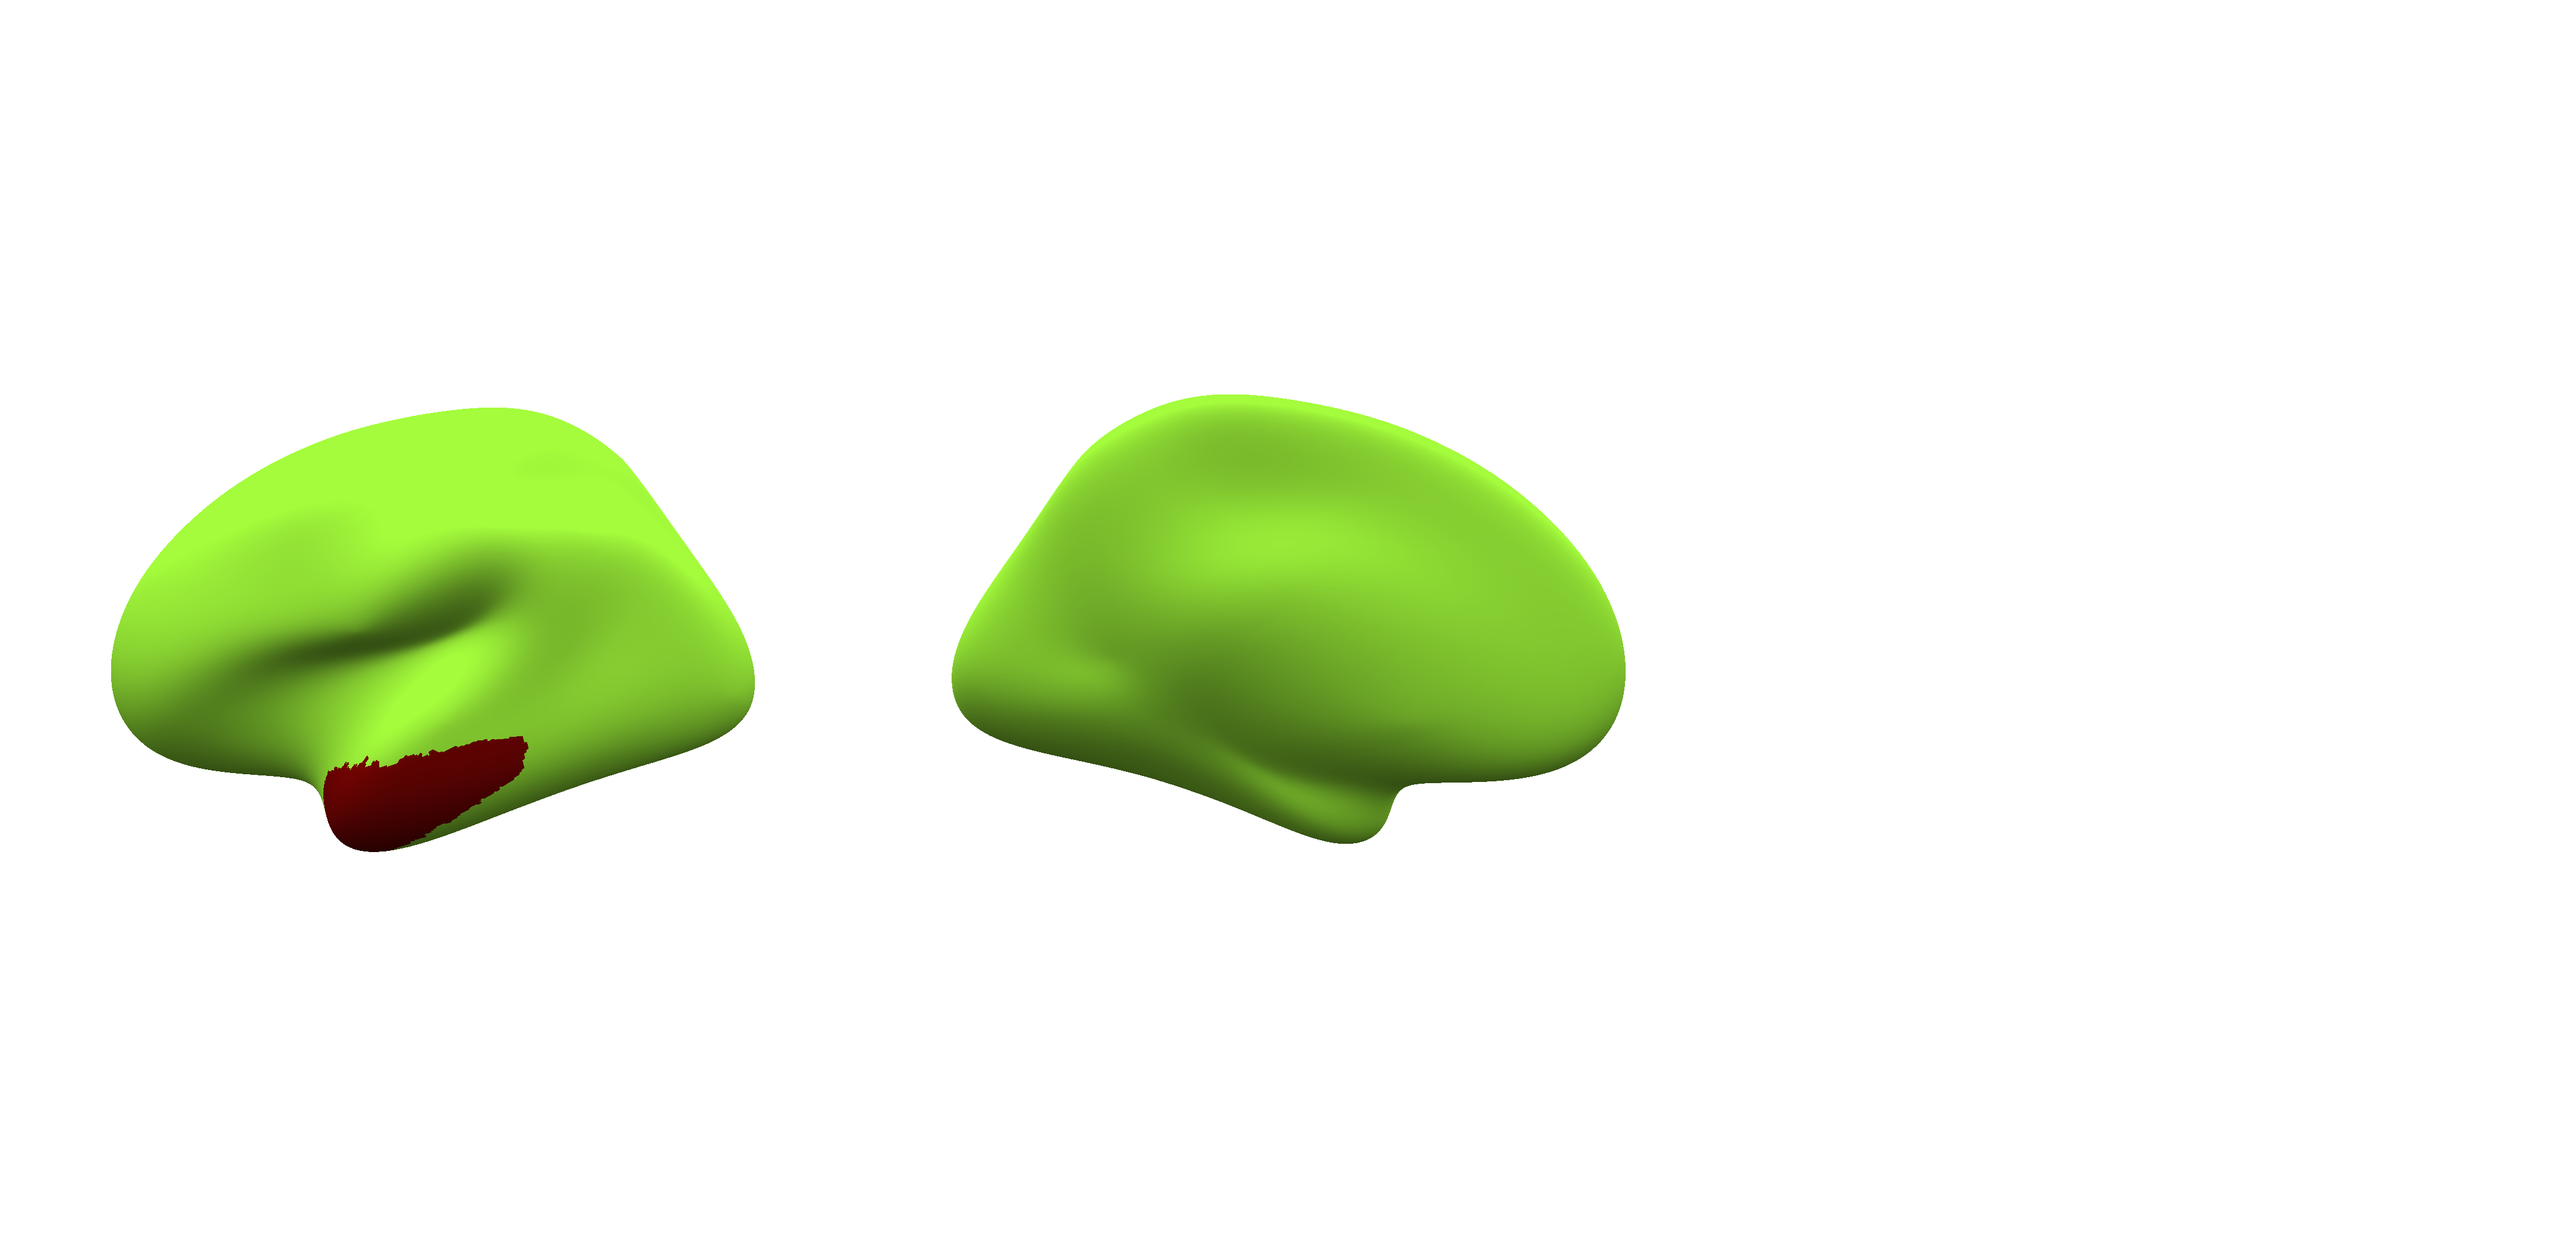

In [42]:
# plot sigmoid results
data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0009']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['right'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0014']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['right'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

data = cohort.split_hemispheres(eva.data_dictionary['MELD_H2_15T_FCD_0015']['cluster_thresholded'])
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], data['left'],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5,
    )

In [14]:
sigmoid(np.array([0,0.2,0.4,0.6,0.8,1]), ymin=0.02, ymax=0.5)

array([0.5       , 0.47176471, 0.35230769, 0.16769231, 0.04823529,
       0.02      ])